# Optimizing over non-float Parameters

Sometimes, you need to optimize a target that is not just a function of floating-point values, but relies on integer or categorical parameters. This notebook shows how such problems are handled by following an approach from ["Dealing with categorical and integer-valued variables in Bayesian Optimization with Gaussian processes" by Garrido-Merchán and Hernández-Lobato](https://arxiv.org/abs/1805.03463). One simple way of handling an integer-valued parameter is to run the optimization as normal, but then round to the nearest integer after a point has been suggested. This method is similar, except that the rounding is performed in the _kernel_. Why does this matter? It means that the kernel is aware that two parameters, that map the to same point but are potentially distinct before this transformation are the same.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

from sklearn.gaussian_process.kernels import Matern

# suppress warnings about this being an experimental feature
warnings.filterwarnings(action="ignore")

## 1. Simple integer-valued function
Let's look at a simple, one-dimensional, integer-valued target function and compare a typed optimizer and a continuous optimizer.

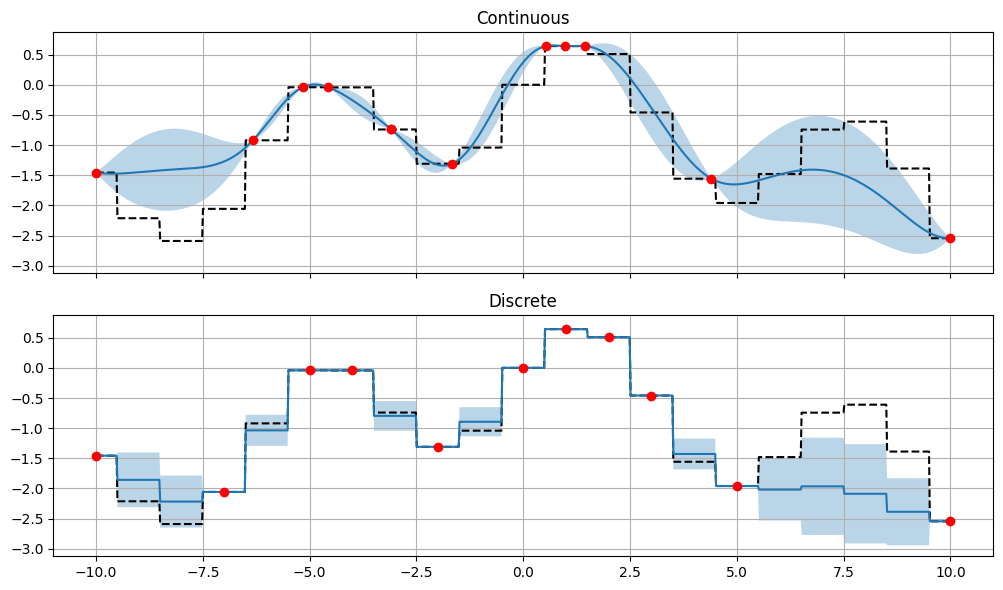

In [2]:
def target_function_1d(x):
    return np.sin(np.round(x)) - np.abs(np.round(x) / 5)

c_pbounds = {'x': (-10, 10)}
bo_cont = BayesianOptimization(target_function_1d, c_pbounds, verbose=0, random_state=1)

# one way of constructing an integer-valued parameter is to add a third element to the tuple
d_pbounds = {'x': (-10, 10, int)}
bo_disc = BayesianOptimization(target_function_1d, d_pbounds, verbose=0, random_state=1)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

bo_cont.maximize(init_points=2, n_iter=10)
bo_cont.acquisition_function._fit_gp(bo_cont._gp, bo_cont.space)

y_mean, y_std = bo_cont._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[0].set_title('Continuous')
axs[0].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[0].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[0].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[0].plot(bo_cont.space.params, bo_cont.space.target, 'ro')

bo_disc.maximize(init_points=2, n_iter=10)
bo_disc.acquisition_function._fit_gp(bo_disc._gp, bo_disc.space)

y_mean, y_std = bo_disc._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[1].set_title('Discrete')
axs[1].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[1].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[1].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[1].plot(bo_disc.space.params, bo_disc.space.target, 'ro')

for ax in axs:
    ax.grid(True)
fig.tight_layout()

We can see, that the discrete optimizer is aware that the function is discrete and does not try to predict values between the integers. The continuous optimizer tries to predict values between the integers, despite the fact that these are known.
We can also see that the discrete optimizer predicts blocky mean and standard deviations, which is a result of the discrete nature of the function.

## 2. Mixed-parameter optimization

In [3]:
def discretized_function(x, y):
    y = np.round(y)
    return (-1*np.cos(x)**np.abs(y) + -1*np.cos(y)) + 0.1 * (x + y) - 0.01 * (x**2 + y**2)

In [4]:
# Bounded region of parameter space
c_pbounds = {'x': (-5, 5), 'y': (-5, 5)}

In [5]:
labels = ["All-float Optimizer", "Typed Optimizer"]

In [6]:
continuous_optimizer = BayesianOptimization(
    f=discretized_function,
    acquisition_function=acquisition.ExpectedImprovement(xi=0.01, random_state=1),
    pbounds=c_pbounds,
    verbose=2,
    random_state=1,
)

continuous_optimizer.set_gp_params(kernel=Matern(nu=2.5, length_scale=np.ones(2)))

d_pbounds = {'x': (-5, 5), 'y': (-5, 5, int)}
discrete_optimizer = BayesianOptimization(
    f=discretized_function,
    acquisition_function=acquisition.ExpectedImprovement(xi=0.01, random_state=1),
    pbounds=d_pbounds,
    verbose=2,
    random_state=1,
)

discrete_optimizer.set_gp_params(kernel=Matern(nu=2.5, length_scale=np.ones(2)));

In [7]:
for lbl, optimizer in zip(labels, [continuous_optimizer, discrete_optimizer]):
    print(f"====================  {lbl}  ====================\n")
    optimizer.maximize(
        init_points=2,
        n_iter=13
    )
    print(f"Max: {optimizer.max['target']}\n\n")

====================  All-float Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 2         | 0.03061   | -0.829779 | 2.2032449 |
| 3         | -0.6535   | -4.998856 | -1.976674 |
| 4         | 0.8025    | -0.829779 | 2.6549696 |
| 5         | 0.9203    | -0.981065 | 2.6644394 |
| 6         | 1.008     | -1.652553 | 2.7133425 |
| 7         | 0.9926    | -1.119714 | 2.8358733 |
| 8         | 1.322     | -2.418942 | 3.4600371 |
| 9         | -0.5063   | -3.092074 | 3.7368226 |
| 10        | -0.6432   | -4.089558 | -0.560384 |
| 11        | 1.267     | -2.360726 | 3.3725022 |
| 12        | 0.4649    | -2.247113 | 3.7419056 |
| 13        | 1.0       | -1.740988 | 3.4854116 |
| 14        | 0.986     | 1.2164322 | 4.4938459 |
| 15        | -2.27     | -2.213867 | 0.3585570 |
| 16        | -1.853    | 1.7935035 | -0.377351 |
Max: 1.321554535694256


====================  Typed Optimizer  ====================


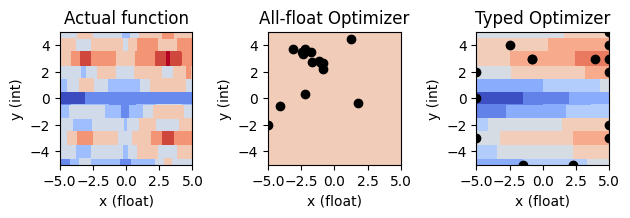

In [8]:
x = np.linspace(c_pbounds['x'][0], c_pbounds['x'][1], 1000)
y = np.linspace(c_pbounds['y'][0], c_pbounds['y'][1], 1000)

X, Y = np.meshgrid(x, y)

Z = discretized_function(X, Y)

params = [{'x': x_i, 'y': y_j} for y_j in y for x_i in x]
array_params = [continuous_optimizer._space.params_to_array(p) for p in params]
c_pred = continuous_optimizer._gp.predict(array_params).reshape(X.shape)
d_pred = discrete_optimizer._gp.predict(array_params).reshape(X.shape)

vmin = np.min([np.min(Z), np.min(c_pred), np.min(d_pred)])
vmax = np.max([np.max(Z), np.max(c_pred), np.max(d_pred)])

fig, axs = plt.subplots(1, 3)

axs[0].set_title('Actual function')
axs[0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)


axs[1].set_title(labels[0])
axs[1].contourf(X, Y, c_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[1].scatter(continuous_optimizer._space.params[:,0], continuous_optimizer._space.params[:,1], c='k')

axs[2].set_title(labels[1])
axs[2].contourf(X, Y, d_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[2].scatter(discrete_optimizer._space.params[:,0], discrete_optimizer._space.params[:,1], c='k')

def make_plot_fancy(ax: plt.Axes):
    ax.set_aspect("equal")
    ax.set_xlabel('x (float)')
    ax.set_xticks([-5.0, -2.5, 0., 2.5, 5.0])
    ax.set_ylabel('y (int)')
    ax.set_yticks([-4, -2, 0, 2, 4])

for ax in axs:
    make_plot_fancy(ax)

plt.tight_layout()
plt.show()

## 3. Categorical variables


We can also handle categorical variables! This is done under-the-hood by constructing parameters in a one-hot-encoding representation, with a transformation in the kernel rounding to the nearest one-hot representation. If you want to use this, you can specify a collection of strings as options.

NB: As internally, the categorical variables are within a range of `[0, 1]` and the GP used for BO is by default isotropic, you might want to ensure your other features are similarly scaled to a range of `[0, 1]` or use an anisotropic GP.

In [9]:
def f1(x1, x2):
    return -1*(x1 - np.sqrt(x1**2 + x2**2) * np.cos(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def f2(x1, x2):
    return -1*(x2 - np.sqrt(x1**2 + x2**2) * np.sin(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def SPIRAL(x1, x2, k):
    """cf Ladislav-Luksan
    """
    if k=='1':
        return f1(10 * x1, 10 * x2)
    elif k=='2':
        return f2(10 * x1, 10 * x2)


In [10]:
pbounds = {'x1': (-1, 1), 'x2': (-1, 1), 'k': ('1', '2')}

categorical_optimizer = BayesianOptimization(
    f=SPIRAL,
    acquisition_function=acquisition.ExpectedImprovement(1e-2),
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)
discrete_optimizer.set_gp_params(alpha=1e-3)

categorical_optimizer.maximize(
        init_points=2,
        n_iter=18,
    )

|   iter    |  target   |    x1     |    x2     |     k     |
-------------------------------------------------------------
| 2         | -2.052    | -0.165955 | 0.4406489 | 2         |
| 3         | 13.49     | -0.743751 | 0.9980810 | 1         |
| 4         | -15.7     | -0.763608 | 0.9785936 | 2         |
| 5         | -0.3783   | -0.093284 | 0.1023150 | 2         |
| 6         | 3.247     | -0.806061 | -0.713343 | 1         |
| 7         | 3.551     | -0.196292 | 0.2582785 | 1         |
| 8         | 6.097     | -0.611686 | -0.354793 | 1         |
| 9         | 0.878     | -0.109889 | -0.701415 | 1         |
| 10        | -13.98    | 0.9422961 | -0.625876 | 1         |
| 11        | -5.565    | 0.8618152 | 0.5454722 | 2         |
| 12        | -5.01     | 0.2751833 | -0.369982 | 1         |
| 13        | -8.922    | -0.635194 | 0.6307052 | 2         |
| 14        | 1.136     | -0.182129 | -0.271731 | 2         |
| 15        | -10.96    | -0.639808 | 0.6662940 | 2         |
| 16    

In [11]:
res = categorical_optimizer._space.res()
k1 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='1'])
k2 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='2'])

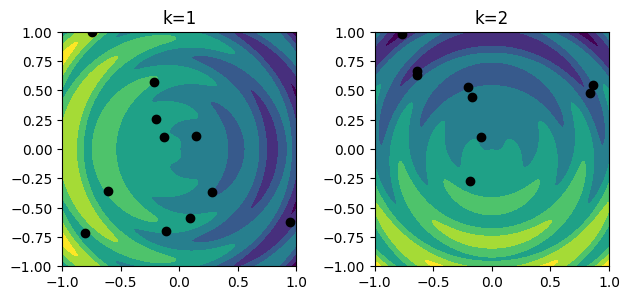

In [12]:
x1 = np.linspace(pbounds['x1'][0], pbounds['x1'][1], 1000)
x2 = np.linspace(pbounds['x2'][0], pbounds['x2'][1], 1000)

X1, X2 = np.meshgrid(x1, x2)
Z1 = SPIRAL(X1, X2, '1')
Z2 = SPIRAL(X1, X2, '2')

fig, axs = plt.subplots(1, 2)

vmin = np.min([np.min(Z1), np.min(Z2)])
vmax = np.max([np.max(Z1), np.max(Z2)])

axs[0].contourf(X1, X2, Z1, vmin=vmin, vmax=vmax)
axs[0].set_aspect("equal")
axs[0].scatter(k1[:,0], k1[:,1], c='k')
axs[1].contourf(X1, X2, Z2, vmin=vmin, vmax=vmax)
axs[1].scatter(k2[:,0], k2[:,1], c='k')
axs[1].set_aspect("equal")
axs[0].set_title('k=1')
axs[1].set_title('k=2')
fig.tight_layout()


## 4. Use in ML

A typical usecase for integer and categorical parameters is optimizing the hyperparameters of a machine learning model. Below you can find an example where the hyperparameters of an SVM are optimized.

In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

data = load_breast_cancer()
X_train, y_train = data['data'], data['target']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
kernels = ['rbf', 'poly']

def f_target(kernel, log10_C):
    if kernel == 'poly2':
        kernel = 'poly'
        degree = 2
    elif kernel == 'poly3':
        kernel = 'poly'
        degree = 3
    elif kernel == 'rbf':
        degree = 3 # not used, equal to default

    C = 10**log10_C

    model = SVC(C=C, kernel=kernel, degree=degree, probability=True, random_state=1)
    model.fit(X_train, y_train)

    # Package looks for maximum, so we return -1 * log_loss
    loss = -1 * log_loss(y_val, model.predict_proba(X_val))
    return loss


params_svm ={
    'kernel': ['rbf', 'poly2', 'poly3'],
    'log10_C':(-1, +1),
}

optimizer = BayesianOptimization(
    f_target,
    params_svm,
    random_state=1,
    verbose=2
)

kernel = Matern(nu=2.5, length_scale=np.ones(optimizer.space.dim))
discrete_optimizer.set_gp_params(kernel=kernel)
optimizer.maximize(init_points=2, n_iter=8)

|   iter    |  target   |  kernel   |  log10_C  |
-------------------------------------------------
| 2         | -0.2361   | poly2     | 0.9943696 |
| 3         | -0.2864   | rbf       | -0.999771 |
| 4         | -0.2625   | poly3     | 0.7449728 |
| 5         | -0.2361   | poly2     | 0.9944598 |
| 6         | -0.298    | poly3     | -0.999625 |
| 7         | -0.2361   | poly2     | 0.9945010 |
| 8         | -0.2152   | rbf       | 0.9928960 |
| 9         | -0.2153   | rbf       | 0.9917667 |
| 10        | -0.2362   | poly2     | 0.9897298 |
| 11        | -0.2362   | poly2     | 0.9874217 |


## 5. Defining your own Parameter

Maybe you want to optimize over another form of parameters, which does not align with `float`, `int` or categorical. For this purpose, you can create your own, custom parameter. A simple example is a parameter that is discrete, but still admits a distance representation (like an integer) while not being uniformly spaced.

However, you can go further even and encode constraints and even symmetries in your parameter. Let's consider the problem of finding a triangle which maximizes an area given its sides $a, b, c$ with a constraint that the perimeter is fixed, i.e. $a + b + c=s$.

We will create a parameter that encodes such a triangle, and via it's kernel transform ensures that the sides sum to the required length $s$. As you might expect, the solution to this problem is an equilateral triangle, i.e. $a=b=c=s/3$.

To define the parameter, we need to subclass `BayesParameter` and define a few important functions/properties.

- `is_continuous` is a property which denotes whether a parameter is continuous. When optimizing the acquisition function, non-continuous parameters will not be optimized using gradient-based methods, but only via random sampling.
- `random_sample` is a function that samples randomly from the space of the parameter.
- `to_float` transforms the canonical representation of a parameter into float values for the target space to store. There is a one-to-one correspondence between valid float representations produced by this function and canonical representations of the parameter. This function is most important when working with parameters that use a non-numeric canonical representation, such as categorical parameters.
- `to_param` performs the inverse of `to_float`: Given a float-based representation, it creates a canonical representation. This function should perform binning whenever appropriate, e.g. in the case of the `IntParameter`, this function would round any float values supplied to it.
- `kernel_transform` is the most important function of the Parameter and defines how to represent a value in the kernel space. In contrast to `to_float`, this function expects both the input, as well as the output to be float-representations of the value.
- `to_string` produces a stringified version of the parameter, which allows users to define custom pretty-print rules for ththe ScreenLogger use.
- `dim` is a property which defines the dimensionality of the parameter. In most cases, this will be 1, but e.g. for categorical parameters it is equivalent to the cardinality of the category space.  

In [14]:
from bayes_opt.logger import ScreenLogger
from bayes_opt.parameter import BayesParameter
from bayes_opt.util import ensure_rng


class FixedPerimeterTriangleParameter(BayesParameter):
    def __init__(self, name: str, bounds, perimeter) -> None:
        super().__init__(name, bounds)
        self.perimeter = perimeter

    @property
    def is_continuous(self):
        return True

    def random_sample(self, n_samples: int, random_state):
        random_state = ensure_rng(random_state)
        samples = []
        while len(samples) < n_samples:
            samples_ = random_state.dirichlet(np.ones(3), n_samples)
            samples_ = samples_ * self.perimeter # scale samples by perimeter

            samples_ = samples_[np.all((self.bounds[:, 0] <= samples_) & (samples_ <= self.bounds[:, 1]), axis=-1)]
            samples.extend(np.atleast_2d(samples_))
        samples = np.array(samples[:n_samples])
        return samples

    def to_float(self, value):
        return value

    def to_param(self, value):
        return value * self.perimeter / sum(value)

    def kernel_transform(self, value):
        return value * self.perimeter / np.sum(value, axis=-1, keepdims=True)

    def to_string(self, value, str_len: int) -> str:
        len_each = (str_len - 2) // 3
        str_ = '|'.join([f"{float(np.round(value[i], 4))}"[:len_each] for i in range(3)])
        return str_.ljust(str_len)

    @property
    def dim(self):
        return 3 # as we have three float values, each representing the length of one side.

def area_of_triangle(sides):
    a, b, c = sides
    s = np.sum(sides, axis=-1) # perimeter
    A = np.sqrt(s * (s-a) * (s-b) * (s-c))
    return A


In [15]:
param = FixedPerimeterTriangleParameter(
    name='sides',
    bounds=np.array([[0., 1.], [0., 1.], [0., 1.]]),
    perimeter=1.
)

pbounds = {'sides': param}
optimizer = BayesianOptimization(
    area_of_triangle,
    pbounds,
    random_state=1,
)

# Increase the cell size to accommodate the three float values
optimizer.logger._verbose = 2
optimizer.logger._default_cell_size = 15
optimizer.logger._is_constrained = False

optimizer.maximize(init_points=2, n_iter=23)

|      iter       |     target      |      sides      |
-------------------------------------------------------
| 2               | 0.4572          | 0.29|0.70|0.00  |
| 3               | 0.5096          | 0.58|0.25|0.15  |
| 4               | 0.5081          | 0.58|0.25|0.15  |
| 5               | 0.5386          | 0.44|0.28|0.26  |
| 6               | 0.5279          | 0.38|0.14|0.47  |
| 7               | 0.5328          | 0.18|0.36|0.45  |
| 8               | 0.4366          | 0.02|0.22|0.74  |
| 9               | 0.4868          | 0.00|0.61|0.37  |
| 10              | 0.4977          | 0.56|0.01|0.42  |
| 11              | 0.5418          | 0.29|0.40|0.30  |
| 12              | 0.3361          | 0.06|0.87|0.06  |
| 13              | 0.06468         | 0.99|0.00|0.00  |
| 14              | 0.01589         | 0.0|0.00|0.99   |
| 15              | 0.4999          | 0.21|0.16|0.61  |
| 16              | 0.499           | 0.53|0.46|0.00  |
| 17              | 0.4937          | 0.00|0.41|

This seems to work decently well, but we can improve it significantly if we consider the symmetries inherent in the problem: This problem is permutation invariant, i.e. we do not care which side specifically is denoted as $a$, $b$ or $c$. Instead, we can, without loss of generality, decide that the shortest side will always be denoted as $a$, and the longest always as $c$. If we enhance our kernel transform with this symmetry, the performance improves significantly. This can be easily done by sub-classing the previously created triangle parameter.

In [16]:
class SortingFixedPerimeterTriangleParameter(FixedPerimeterTriangleParameter):
    def __init__(self, name: str, bounds, perimeter) -> None:
        super().__init__(name, bounds, perimeter)

    def to_param(self, value):
        value = np.sort(value, axis=-1)
        return super().to_param(value)

    def kernel_transform(self, value):
        value = np.sort(value, axis=-1)
        return super().kernel_transform(value)

param = SortingFixedPerimeterTriangleParameter(
    name='sides',
    bounds=np.array([[0., 1.], [0., 1.], [0., 1.]]),
    perimeter=1.
)

pbounds = {'sides': param}
optimizer = BayesianOptimization(
    area_of_triangle,
    pbounds,
    random_state=1,
)

optimizer.logger.verbose = 2
optimizer.logger._default_cell_size = 15

optimizer.maximize(init_points=2, n_iter=8)

|      iter       |     target      |      sides      |
-------------------------------------------------------
| 2               | 0.4572          | 0.00|0.29|0.70  |
| 3               | 0.5096          | 0.15|0.25|0.58  |
| 4               | 0.498           | 0.06|0.33|0.60  |
| 5               | 0.5097          | 0.13|0.27|0.58  |
| 6               | 0.5358          | 0.19|0.36|0.43  |
| 7               | 0.5443          | 0.33|0.33|0.33  |
| 8               | 0.5405          | 0.28|0.28|0.42  |
| 9               | 0.5034          | 0.01|0.49|0.49  |
| 10              | 0.4977          | 0.01|0.42|0.56  |
| 11              | 0.5427          | 0.27|0.36|0.36  |
